## 主要是如何检测一个物体是否为矩形，又或者为圆形

这里以**增强边缘检测**为起始

这是一个 Pillow 图像。


(-0.5, 3999.5, 2999.5, -0.5)

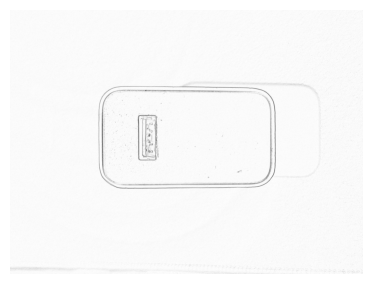

In [6]:
import numpy as np
from PIL import Image
import os
import matplotlib.pyplot as plt

# 灰度图
def process_image(image_path, depth=10):
    # 加载并转换图像为灰度图
    array = np.asarray(Image.open(image_path).convert('L')).astype(np.float64)

    # 提取x y方向梯度值
    grad_x, grad_y = np.gradient(array)

    # 利用虚拟深度值调整梯度
    grad_x = grad_x * depth / 100
    grad_y = grad_y * depth / 100

    # 梯度归一化
    dis = np.sqrt(grad_x ** 2 + grad_y ** 2 + 1.0)
    uni_x = grad_x / dis
    uni_y = grad_y / dis
    uni_z = 1.0 / dis

    # 光源俯视角度和光源方位角度
    vec_el = np.pi / 2.2
    vec_az = np.pi / 4

    # 光源对x、y、z轴的影响
    dx = np.cos(vec_el) * np.cos(vec_az)
    dy = np.cos(vec_el) * np.sin(vec_az)
    dz = np.sin(vec_el)

    # 计算光照效果
    out = 255 * (uni_x * dx + uni_y * dy + uni_z * dz)
    out = out.clip(0, 255)
    img = Image.fromarray(out.astype(np.uint8))
    return img


def check_image_type(img):
    if isinstance(img, np.ndarray):
        print("这是一个 OpenCV 图像 (NumPy 数组)。")
    if isinstance(img, Image.Image):
        print("这是一个 Pillow 图像。")

# 输入图像路径
image_path = "fin3.jpg" 

processed_image = process_image(image_path)

check_image_type(processed_image)
processed_image_array = np.array(processed_image)  # 转换为 NumPy 数组
plt.imsave("processed_image.jpg", processed_image_array, cmap='gray')
plt.figure(figsize=(10, 5))
# 显示原始图像
plt.subplot(1, 2, 1)
plt.imshow(processed_image, cmap='gray')
plt.axis('off')




In [9]:
import cv2
import numpy as np
from PIL import Image, ImageDraw, ImageFont


def compute_curvature(contour, window_size=5):
    curvature = []
    n = len(contour)
    for i in range(n):
        window = [contour[(i + j) % n][0] for j in range(-window_size, window_size + 1)]
        x = np.arange(-window_size, window_size + 1)
        y = np.array([p[1] for p in window])
        z = np.polyfit(x, y, 2)
        deriv_1 = np.polyder(z, 1)
        deriv_2 = np.polyder(z, 2)
        curvature.append(np.abs(deriv_2[0]) / (1 + deriv_1[0] ** 2) ** 1.5)
    return curvature


def calculate_angle(p1, p2, p3):
    v1 = p1 - p2
    v2 = p3 - p2

    norm_v1 = np.linalg.norm(v1)
    norm_v2 = np.linalg.norm(v2)

    if norm_v1 == 0 or norm_v2 == 0:
        return 0.0  # 避免零向量的情况

    cos_angle = np.dot(v1, v2) / (norm_v1 * norm_v2)
    cos_angle = np.clip(cos_angle, -1.0, 1.0)  # 裁剪值以避免超出合法范围

    angle = np.arccos(cos_angle)
    return np.degrees(angle)


def classify_curve(angles, curvatures):
    angle_std = np.std(angles)
    max_curvature = max(curvatures)
    print("角度列表:", angles)
    print("曲率列表:", curvatures)
    print("角度标准差:", angle_std)
    print("最大曲率:", max_curvature)

    if angle_std == 0 and len(set(angles)) == 1:
        return "正常矩形"

    if angle_std < 5 and max_curvature < 0.005:
        return "直线"  # 没有
    elif angle_std < 62 and max_curvature < 0.16:
        return "弯曲"
    elif angle_std < 65 and max_curvature < 0.17:
        return "中度弯曲"
    elif angle_std < 68 and max_curvature < 0.25:
        return "弯曲++"
    elif angle_std < 70 and max_curvature < 0.35:
        return "弯曲+"
    else:
        return "弯曲??"



def add_chinese_text(image, text, position, font_size=20):
    # 将 OpenCV 图像转换为 PIL 图像
    image_pil = Image.fromarray(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    draw = ImageDraw.Draw(image_pil)

    # 使用支持中文的字体
    font = ImageFont.truetype("msyh.ttc", font_size, encoding="utf-8")
    draw.text(position, text, font=font, fill=(255, 0, 0))

    # 将 PIL 图像转换回 OpenCV 图像
    return cv2.cvtColor(np.array(image_pil), cv2.COLOR_RGB2BGR)


def analyze_shape(image_path):
    image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    _, binary = cv2.threshold(image, 128, 255, cv2.THRESH_BINARY_INV)
    binary = cv2.GaussianBlur(binary, (5, 5), 0)
    contours, _ = cv2.findContours(binary, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    color_image = cv2.cvtColor(image, cv2.COLOR_GRAY2BGR)

    for contour in contours:
        curvature = compute_curvature(contour)
        cv2.drawContours(color_image, [contour], -1, (0, 255, 0), 2)

        angles = []
        n = len(contour)
        for i in range(n):
            p1 = contour[i][0]
            p2 = contour[(i + n // 10) % n][0]
            p3 = contour[(i + 2 * n // 10) % n][0]
            angle = calculate_angle(p1, p2, p3)
            angles.append(angle)

        curve_type = classify_curve(angles, curvature)
        print(f"曲线类型: {curve_type}")

        for i, (curv, angle) in enumerate(zip(curvature, angles)):
            if curv > np.mean(curvature) + 2 * np.std(curvature):
                cv2.circle(color_image, tuple(contour[i][0]), 5, (0, 0, 255), -1)
                cv2.putText(color_image, f"{angle:.1f}", tuple(contour[i][0]),
                            cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 0, 0), 1)

        color_image = add_chinese_text(color_image, f"曲线类型: {curve_type}", (10, 30), font_size=30)
    cv2.imwrite('yes_box.jpg', color_image)
    cv2.imshow('Contour Analysis', color_image)
    cv2.waitKey(0)
    cv2.destroyAllWindows()


# 使用示例
analyze_shape('fin3.png')



ModuleNotFoundError: No module named 'cv2'